In [127]:
import harmonypy as hm
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import umap
import glob
from pathlib import Path
import seaborn as sns
import time

%matplotlib inline

In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local","")
    root_dir = "/".join(base_dir.split("/")[:-1])

    wk_dir = base_dir + "/1_Harmony"
    Path(wk_dir).mkdir(parents=True, exist_ok=True)
else:
    print("Reload")

Start


In [7]:
os.chdir(wk_dir)
input_dir = base_dir + '/0_input'
root_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC'

---
## 0. Pre Process Inputs

In [69]:
###----- Normalized to 10e4 per cell --> Log natural base (x+1)
JC_expr_scaled_file = input_dir + '/all_norm_counts_named_log_scaled.csv'
exp391_expr_scaled_file = root_dir + \
    '/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/counts_XL_folder/all_norm_counts_named_log_scaled.csv'

JC_expr_scaled_tb = pd.read_csv(JC_expr_scaled_file)
exp391_expr_scaled_tb = pd.read_csv(exp391_expr_scaled_file)

# Unify column names
JC_expr_scaled_tb.columns = ["cell_id"] + list(JC_expr_scaled_tb.columns)[1:]
exp391_expr_scaled_tb.columns = ["cell_id"] +  list(exp391_expr_scaled_tb.columns)[1:]

In [99]:
###----- Read obs files, select highly variable genes & used cells
# Analyzed cells
exp391_obs = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/0_Acute-Chronic_paga/obs.csv'
exp391_obs_tb = pd.read_csv(exp391_obs)
exp391_obs_tb.columns = ['cell_id'] + list(exp391_obs_tb.columns)[1:]
exp391_obs_tb = exp391_obs_tb[['cell_id','cell_type','louvain']]
exp391_obs_tb['dataset'] = ['Exp391' for x in exp391_obs_tb['cell_id']]

exp391_expr_scaled_tb = exp391_expr_scaled_tb.loc[exp391_expr_scaled_tb['cell_id'].
                                                  isin(list(exp391_obs_tb['cell_id']))]

# Common genes in datasets
print("John Chang Dataset Genes #:", len(set(JC_expr_scaled_tb.columns[1:])), 
      ", Exp391 Genes #:", len(set(exp391_expr_scaled_tb.columns[1:])))
common_genes = set(JC_expr_scaled_tb.columns[1:]) & set(exp391_expr_scaled_tb.columns[1:])
print("Common Genes #:", len(common_genes))

JC_expr_scaled_tb = JC_expr_scaled_tb[['cell_id'] + list(common_genes)]
exp391_expr_scaled_tb = exp391_expr_scaled_tb[['cell_id'] + list(common_genes)]

all_expr_scaled_tb = pd.concat([exp391_expr_scaled_tb, JC_expr_scaled_tb])

John Chang Dataset Genes #: 2703 , Exp391 Genes #: 2703
Common Genes #: 2703


In [188]:
###----- Creat metadata
exp391_meta = pd.DataFrame({'cell_id':list(exp391_expr_scaled_tb['cell_id'])})
exp391_meta = pd.merge(exp391_meta, exp391_obs_tb, on='cell_id', how='left')

exp391_meta = exp391_meta[['cell_id','cell_type']]
exp391_meta['dataset'] = ['Exp391' for x in exp391_meta['cell_id']]

# Check if meta order match with data order
check_order_391 = [0 if x == y else 1 for index, (x, y) in 
                   enumerate(zip(exp391_meta['cell_id'], exp391_expr_scaled_tb['cell_id']))]
print(np.sum(check_order_391))

JC_sra_meta_file = input_dir + '/SraRunTable.csv'
JC_sra_meta_df = pd.read_csv(JC_sra_meta_file)
JC_sra_meta_df = JC_sra_meta_df[JC_sra_meta_df['Replicate'].notna()][['subtype','Replicate']]
JC_sra_meta_df.columns = ['cell_type', 'cell_id']

JC_meta = pd.DataFrame(JC_expr_scaled_tb['cell_id'])
JC_meta['dataset'] = ['JC' for i in JC_meta['cell_id']]
JC_meta = JC_meta.merge(JC_sra_meta_df, on='cell_id', how='left')

all_meta = pd.concat([exp391_meta, JC_meta])

0


# Run PCA

In [193]:
expr_scaled_tb = all_expr_scaled_tb
meta_tb = all_meta

In [114]:
expr_scaled_tb = expr_scaled_tb.set_index("cell_id")
expr_scaled_arr = expr_scaled_tb.to_numpy()

pca = PCA(n_components=30)
pca.fit(expr_scaled_arr)
expr_scaled_arr_pca = pca.fit_transform(expr_scaled_arr)

expr_scaled_arr_pca.shape

(8082, 30)

<BarContainer object of 30 artists>

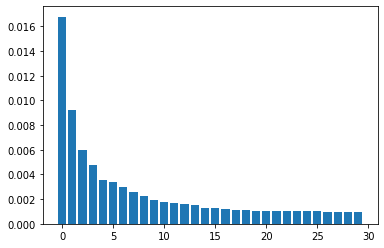

In [115]:
# Explained variance
plt.bar(list(range(0, 30)), pca.explained_variance_ratio_[:30])

## Overlap

<AxesSubplot:xlabel='pc2', ylabel='pc3'>

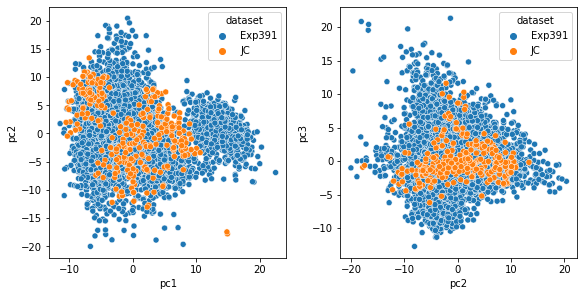

In [126]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=False, 
                         figsize=(8,4), constrained_layout = True)

plot_tb = pd.DataFrame({'pc1':expr_scaled_arr_pca[:,0], 'pc2':expr_scaled_arr_pca[:,1], 
                        'pc3':expr_scaled_arr_pca[:,2], 'dataset':meta_tb['dataset']})
sns.scatterplot(data=plot_tb, x='pc1', y='pc2', hue='dataset', ax=axes[0])
sns.scatterplot(data=plot_tb, x='pc2', y='pc3', hue='dataset', ax=axes[1])

# Run Harmony

In [128]:
time.pre = time.time()
ho = hm.run_harmony(expr_scaled_arr_pca, meta_tb, ['dataset'])
time.post = time.time()

runtime = time.post - time.pre
print("Total Runtime in seconds: %s"%runtime)

2021-12-07 13:21:12,306 - harmonypy - INFO - Iteration 1 of 10
2021-12-07 13:21:13,543 - harmonypy - INFO - Iteration 2 of 10
2021-12-07 13:21:14,828 - harmonypy - INFO - Converged after 2 iterations


Total Runtime in seconds: 4.186884880065918


In [129]:
###----- Save output
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
res.to_csv("adj.tsv.gz", sep = "\t", index = False)

<AxesSubplot:xlabel='pc2', ylabel='pc3'>

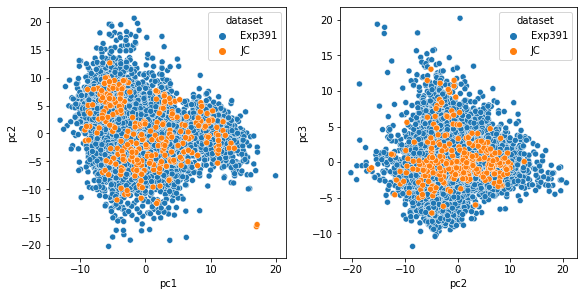

In [133]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=False, 
                         figsize=(8,4), constrained_layout = True)

plot_tb = pd.DataFrame({'pc1':ho.Z_corr[0], 'pc2':ho.Z_corr[1], 
                        'pc3':ho.Z_corr[2], 'dataset':meta_tb['dataset']})
sns.scatterplot(data=plot_tb, x='pc1', y='pc2', hue='dataset', ax=axes[0])
sns.scatterplot(data=plot_tb, x='pc2', y='pc3', hue='dataset', ax=axes[1])

# Run UMAP with Harmony adjusted PCs

In [134]:
reducer = umap.UMAP(n_neighbors = 250, random_state=123)
umap_embedding = reducer.fit_transform(ho.Z_corr.transpose())
reducer_graph = pd.DataFrame.sparse.from_spmatrix(reducer.graph_)

In [196]:
plot_tb = meta_tb
plot_tb['umap1'] = umap_embedding[:,0]
plot_tb['umap2'] = umap_embedding[:,1]
plot_tb_exp391 = plot_tb[plot_tb['dataset'] == 'Exp391']
plot_tb_JC = plot_tb[plot_tb['dataset'] == 'JC']

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

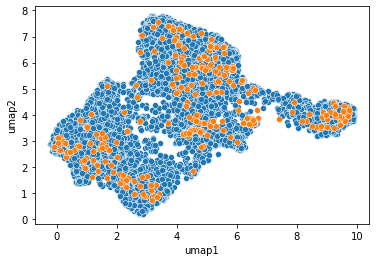

In [197]:
sns.scatterplot(data=plot_tb_exp391, x='umap1', y='umap2')
sns.scatterplot(data=plot_tb_JC, x='umap1', y='umap2')

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

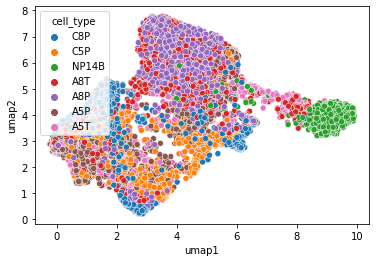

In [204]:
sns.scatterplot(data=plot_tb_exp391, x='umap1', y='umap2', hue='cell_type')

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

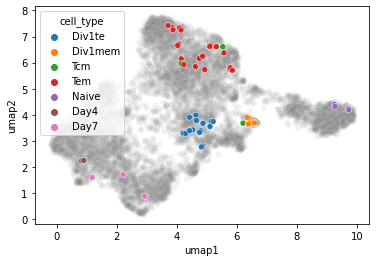

In [203]:
sns.scatterplot(data=plot_tb_exp391, x='umap1', y='umap2', color='gray', alpha=0.1)
sns.scatterplot(data=plot_tb_JC, x='umap1', y='umap2', hue='cell_type')